# Planar data classification with one hidden layer

Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


## 1 - Packages ##

Let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [2]:
X, Y = load_planar_dataset() 

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

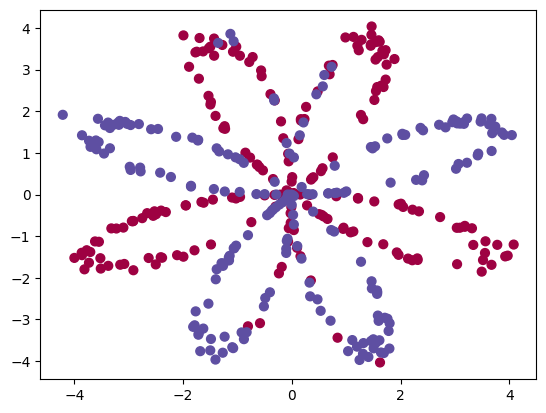

In [3]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral)

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

**Hint**: How do you get the shape of a numpy array? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X, shape_Y, m = X.shape, Y.shape, Y.size



### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:20%">
  
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td> 
  </tr>
  
    <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [5]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y[0, :].T)

LogisticRegressionCV()

You can now plot the decision boundary of these models. Run the code below.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


C:\Users\26271\AppData\Local\Temp\ipykernel_7000\2885141722.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +


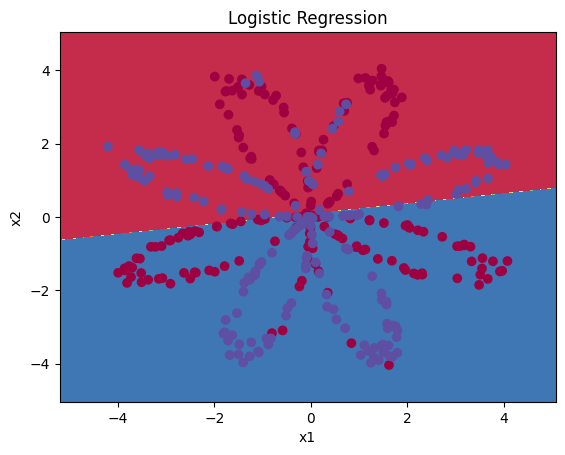

In [6]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y[0, :])
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$
y^{(i)}_{\text{prediction}} =
\begin{cases} 
1 & \text{if } a^{[2](i)} > 0.5, \\ 
0 & \text{otherwise.} 
\end{cases}
\tag{5}
$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure ####

**Exercise**: Define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [9]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]   
    
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [10]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Expected Output** (these are not the sizes you will use for your network, they are just used to assess the function you've just coded).

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  
  <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  
  <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 - Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [13]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))   
    
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [14]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - The Loop ####

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [17]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = parameters["W1"] @ X + parameters["b1"]
    A1 = np.tanh(Z1)
    Z2 = parameters["W2"] @ A1 + parameters["b2"]
    A2 = sigmoid(Z2)
    
       
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)

    
    
    
    
    ### END CODE HERE ###

    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [18]:
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))
print(A2.shape)
print(X_assess.shape)

-0.0004997557777419913 -0.000496963353231779 0.00043818745095914653 0.500109546852431
(1, 3)
(2, 3)


**Expected Output**:
<table style="width:55%">
  <tr>
    <td> -0.000499755777742 -0.000496963353232 0.000438187450959 0.500109546852 </td> 
  </tr>
</table>

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. To help you, we give you how we would have implemented
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(you can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).


In [23]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    cost = -1 / m * (Y @ np.log(A2.T) + (1 - Y) @ np.log(1 - A2.T))
                    # no need to use a for loop!

    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    cost = float(cost)
    assert(isinstance(cost, float))
    
    return cost

In [24]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6929198937761265


**Expected Output**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.692919893776 </td> 
  </tr>
  
</table>

Using the cache computed during forward propagation, you can now implement backward propagation.

**Question**: Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [25]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1, W2 = parameters["W1"], parameters["W2"]
    
    
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1, A2 = cache["A1"], cache["A2"]
    
    
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = A2 - Y
    dW2 = 1 / m * dZ2 @ A1.T
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T @ dZ2 * (1 - np.power(A1, 2))
    dW1 = 1 / m * dZ1 @ X.T
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [26]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


**Expected output**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00363613  0.03153604  0.01162914 -0.01318316]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[ 0.06589489]] </td> 
  </tr>
  
</table>  

**Question**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [27]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    
    
    
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1, db1, dW2, db2 = grads["dW1"], grads["db1"], grads["dW2"], grads["db2"]
    
    
    
    
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [28]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


**Expected Output**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [29]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    
    
    
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [30]:
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

C:\Users\26271\AppData\Local\Temp\ipykernel_7000\1727134312.py:20: RuntimeWarning: divide by zero encountered in log
  cost = -1 / m * (Y @ np.log(A2.T) + (1 - Y) @ np.log(1 - A2.T))
e:\Onedrive\Code\VsCode\Py_Work\Machine_Learning\DeepLearning\吴恩达深度学习\Code\Lesson1\Week3\Planar data classification with one hidden layer\planar_utils.py:34: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-4.18488513  5.33221969]
 [-7.52993947  1.24303243]
 [-4.19252409  5.32657006]
 [ 7.52992652 -1.24303864]]
b1 = [[ 2.32931821]
 [ 3.79449797]
 [ 2.33010292]
 [-3.79451364]]
W2 = [[-6033.83646944 -6008.1295576  -6033.10068915  6008.06587677]]
b2 = [[-52.66631155]]


**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-4.18494056  5.33220609]
 [-7.52989382  1.24306181]
 [-4.1929459   5.32632331]
 [ 7.52983719 -1.24309422]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 2.32926819]
 [ 3.79458998]
 [ 2.33002577]
 [-3.79468846]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-6033.83672146 -6008.12980822 -6033.10095287  6008.06637269]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[-52.66607724]] </td> 
  </tr>
  
</table>  

### 4.5 Predictions

**Question**: Use your model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [35]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5
    
    ### END CODE HERE ###
    
    return predictions

In [36]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


**Expected Output**: 


<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219495
Cost after iteration 9000: 0.218568


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

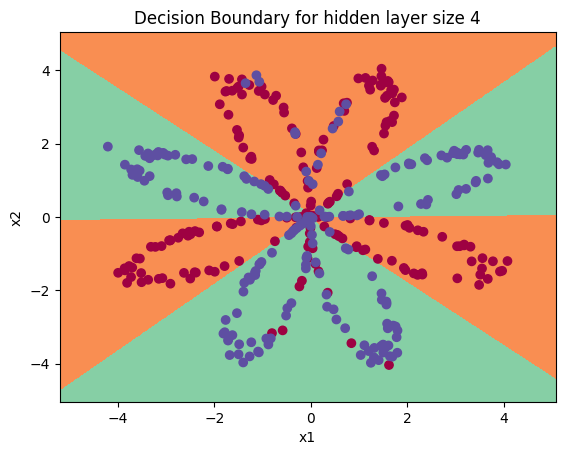

In [37]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0, :])
plt.title("Decision Boundary for hidden layer size " + str(4))

**Expected Output**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [38]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


C:\Users\26271\AppData\Local\Temp\ipykernel_7000\3101546138.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')


**Expected Output**: 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

### 4.6 - Tuning hidden layer size (optional/ungraded exercise) ###

Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes.

C:\Users\26271\AppData\Local\Temp\ipykernel_7000\4198004005.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 10 hidden units: 90.25 %
Accuracy for 20 hidden units: 90.5 %


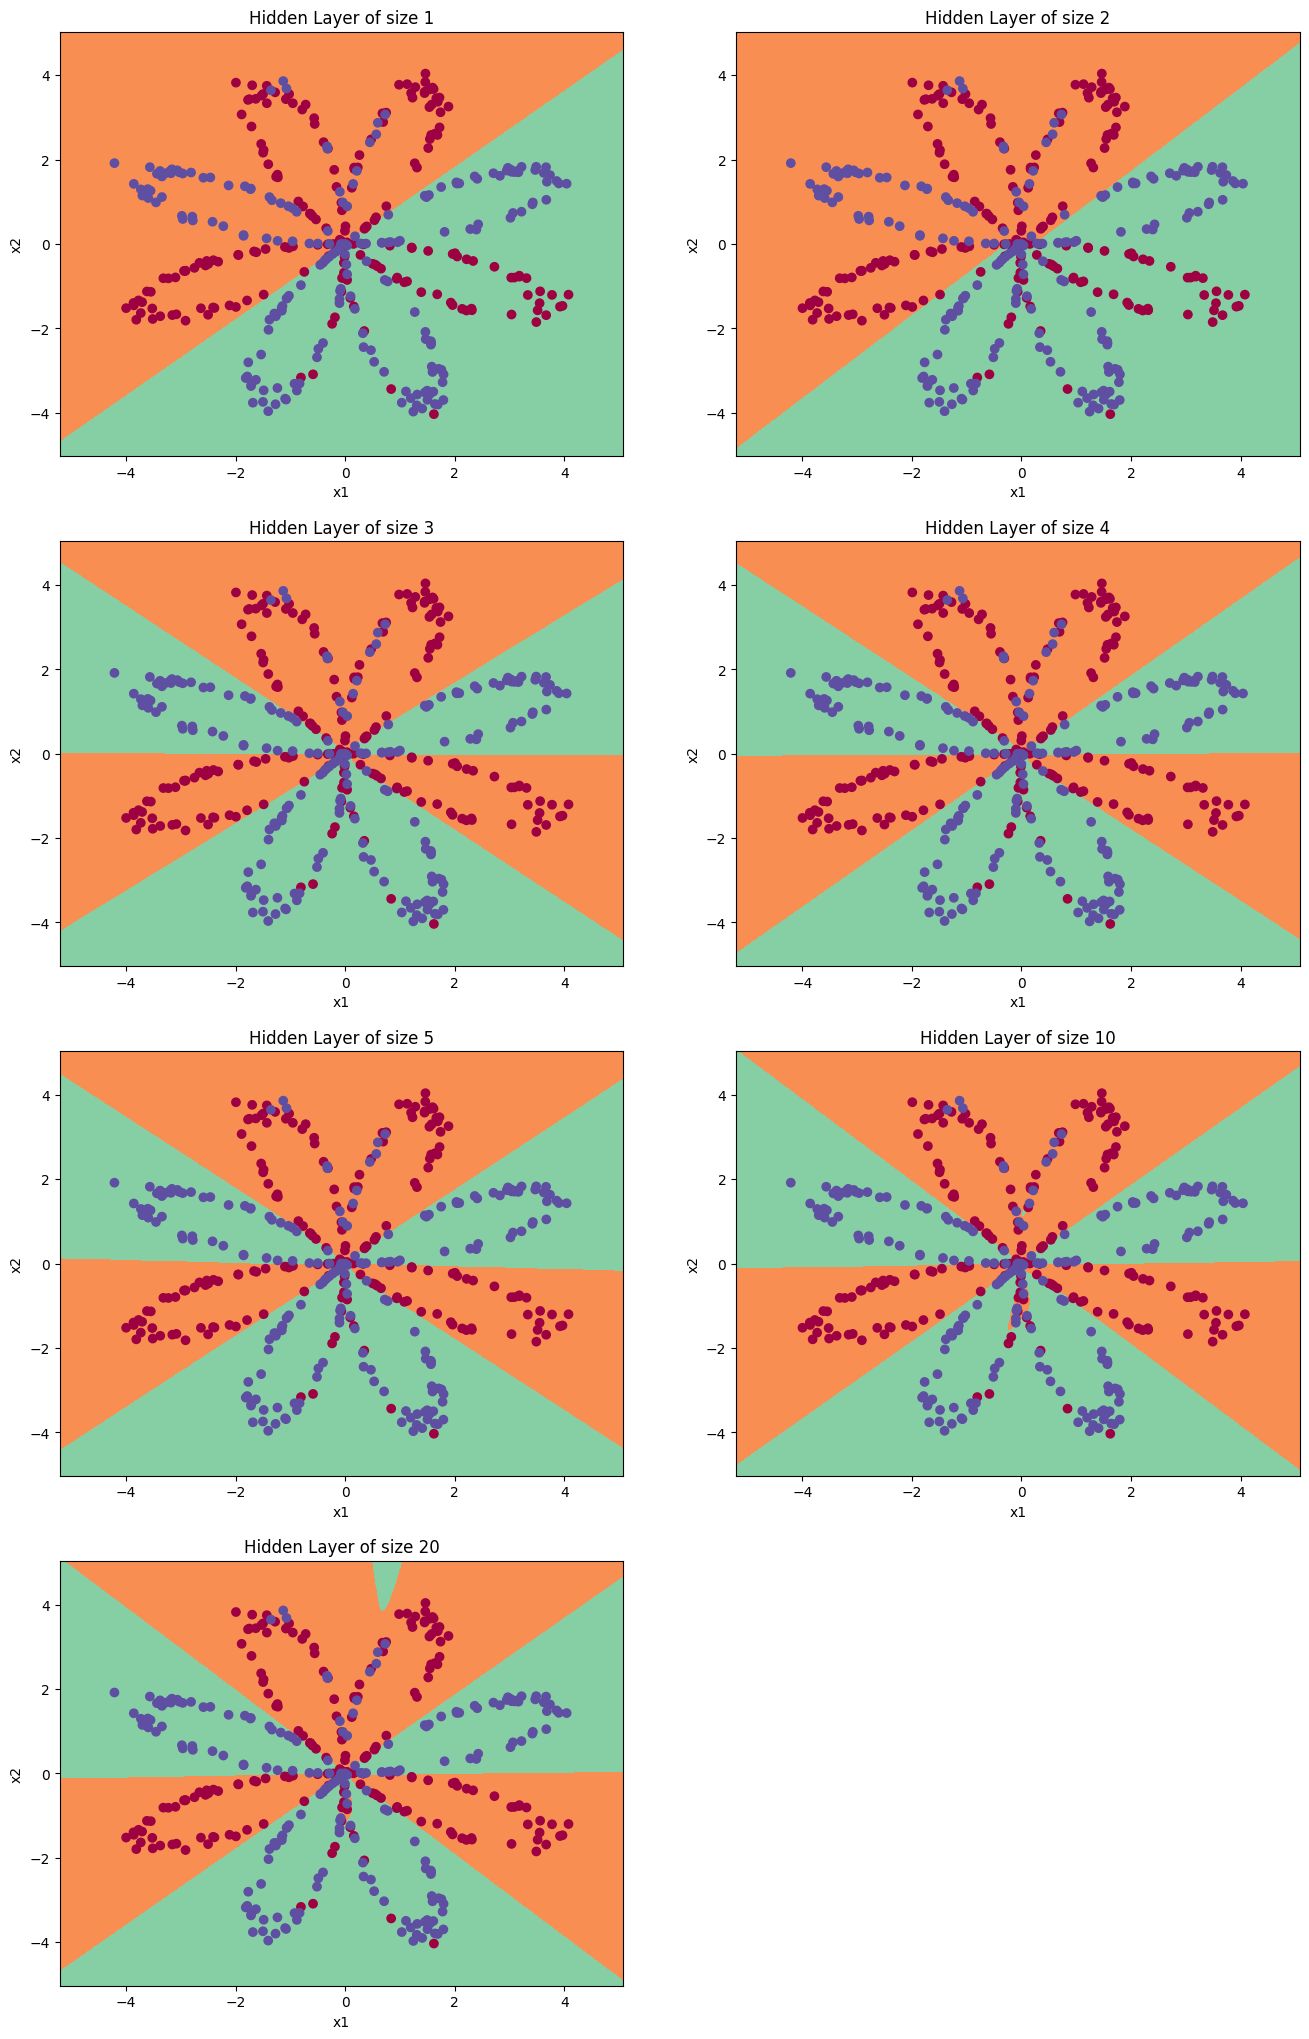

In [39]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0, :])
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.
- You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

**Optional questions**:

**Note**: Remember to submit the assignment but clicking the blue "Submit Assignment" button at the upper-right. 

Some optional/ungraded questions that you can explore if you wish: 
- What happens when you change the tanh activation for a sigmoid activation or a ReLU activation?
- Play with the learning_rate. What happens?
- What if we change the dataset? (See part 5 below!)

<font color='blue'>
**You've learnt to:**
- Build a complete neural network with a hidden layer
- Make a good use of a non-linear unit
- Implemented forward propagation and backpropagation, and trained a neural network
- See the impact of varying the hidden layer size, including overfitting.

Nice work! 

## 5) Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

Cost after iteration 0: 0.692999
Cost after iteration 1000: 0.123979
Cost after iteration 2000: 0.074750
Cost after iteration 3000: 0.071023
Cost after iteration 4000: 0.069439
Cost after iteration 5000: 0.067783
Cost after iteration 6000: 0.065600
Cost after iteration 7000: 0.064917
Cost after iteration 8000: 0.064568
Cost after iteration 9000: 0.064328


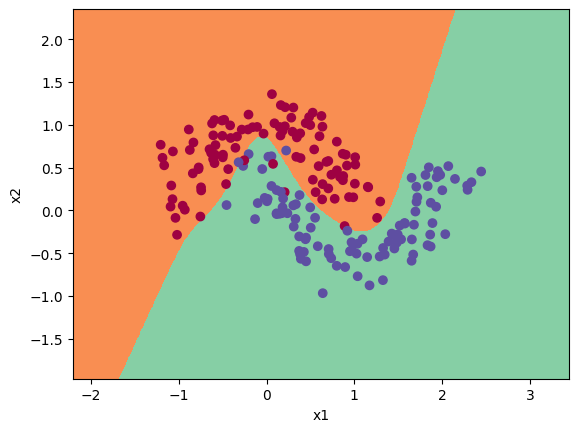

In [41]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral)

# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0, :])

Congrats on finishing this Programming Assignment!

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/